In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr, mode
from scipy.signal import argrelextrema, savgol_filter, medfilt
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit, minimize

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)

import celerite
from celerite import terms
import autograd.numpy as anp

from tinygp import kernels, GaussianProcess

from pytisean import tiseano, tiseanio

In [2]:
matplotlib.rcParams['font.family'] = ['serif']

In [3]:
speculoos = np.genfromtxt("./speculoos_style_M8.txt") #Teff = 2592; Prot = 0.21265815403868307 d

#For now, don't worry about the scattered few speculoos obs taken post-covid 
speculoos_trunc = speculoos[(speculoos[:,0] < 2458247)]

kepler = np.genfromtxt("./kepler_style_G4.txt")       #Teff = 5687; Prot = 26.536163091164116 d (but evolving)
tess = np.genfromtxt("./TESS_style_F8.txt")           #Teff = 6060; Prot ~= 2.8 - 5.6 d (evolving)

print(np.shape(speculoos))
print(np.shape(kepler))
print(np.shape(tess))

(7275, 3)
(64887, 4)
(205351, 4)


(6788,)
(6788,)


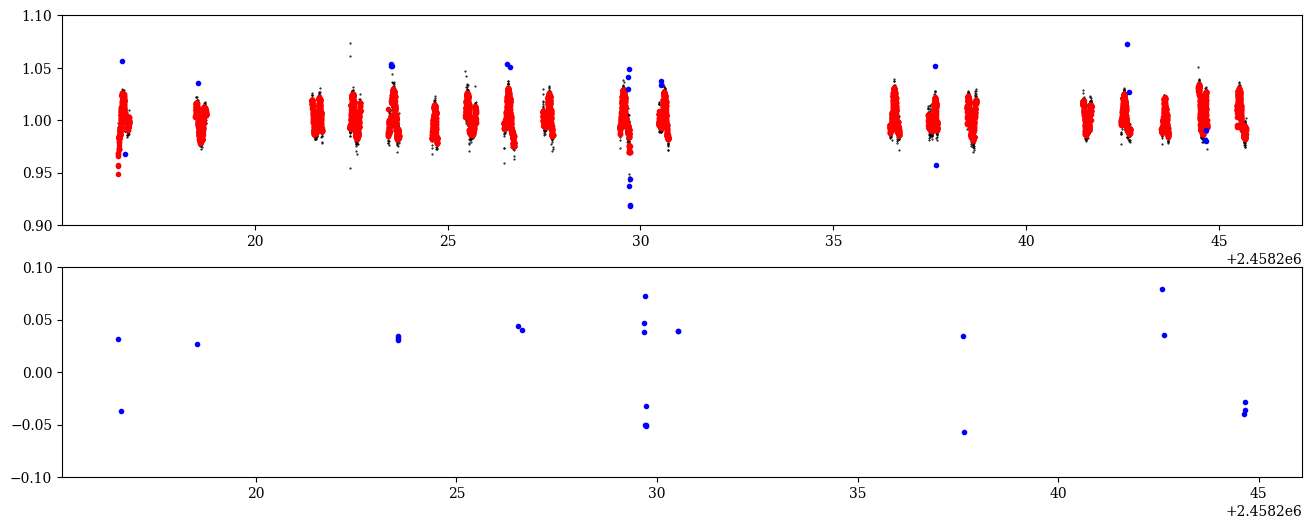

30
0.00441956393635828
6758


In [4]:
# eliminate speculoos flux outliers
movingmed = medfilt(speculoos_trunc[:,1], kernel_size = 15) #chose this kernel size as covering ~0.05*Prot
print(np.shape(movingmed))
print(np.shape(speculoos_trunc[:,1]))

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(speculoos_trunc[:,0],speculoos_trunc[:,1],'k.',ms=1,zorder=1)
axes[0].plot(speculoos_trunc[:,0],movingmed,'r.',zorder=2)
axes[0].set_ylim(0.9,1.1)


outlierMask = (np.abs(speculoos_trunc[:,1] - movingmed) > 5.*speculoos_trunc[:,2])

axes[0].plot(speculoos_trunc[:,0][outlierMask],speculoos_trunc[:,1][outlierMask],'b.',zorder=3)

axes[1].plot(speculoos_trunc[:,0][outlierMask],speculoos_trunc[:,1][outlierMask]-movingmed[outlierMask],'b.')
axes[1].set_ylim(-0.1,0.1)
plt.show()

print(len(speculoos_trunc[:,0][outlierMask]))
print(len(speculoos_trunc[:,0][outlierMask])/len(speculoos_trunc[:,0]))

speculoos_trunc = speculoos_trunc[~outlierMask]
print(len(speculoos_trunc))

(64887,)
(64887,)


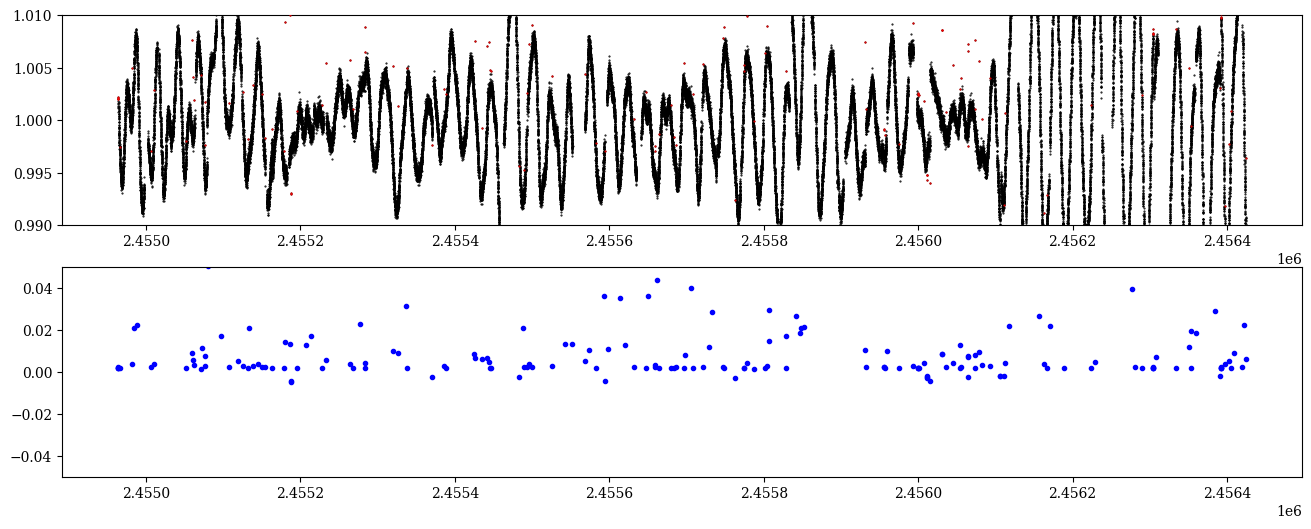

191
0.0029435788370551883
64696


In [5]:
# eliminate kepler flux outliers
movingmed = medfilt(kepler[:,1],kernel_size=65) #chose this kernel size as covering ~0.05*Prot
print(np.shape(movingmed))
print(np.shape(kepler[:,1]))

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(kepler[:,0],kepler[:,1],'k.',ms=1,zorder=1)
#axes[0].plot(kepler[:,0],movingmed,'r.',zorder=2)
axes[0].set_ylim(0.99,1.01)


outlierMask = (np.abs(kepler[:,1] - movingmed) > 5.*kepler[:,2])

axes[0].plot(kepler[:,0][outlierMask],kepler[:,1][outlierMask],'r.',ms=1,zorder=3)

axes[1].plot(kepler[:,0][outlierMask],kepler[:,1][outlierMask]-movingmed[outlierMask],'b.')
axes[1].set_ylim(-0.05,0.05)
plt.show()

print(len(kepler[:,0][outlierMask]))
print(len(kepler[:,0][outlierMask])/len(kepler[:,0]))

kepler = kepler[~outlierMask]
print(len(kepler))

(205351,)
(205351,)


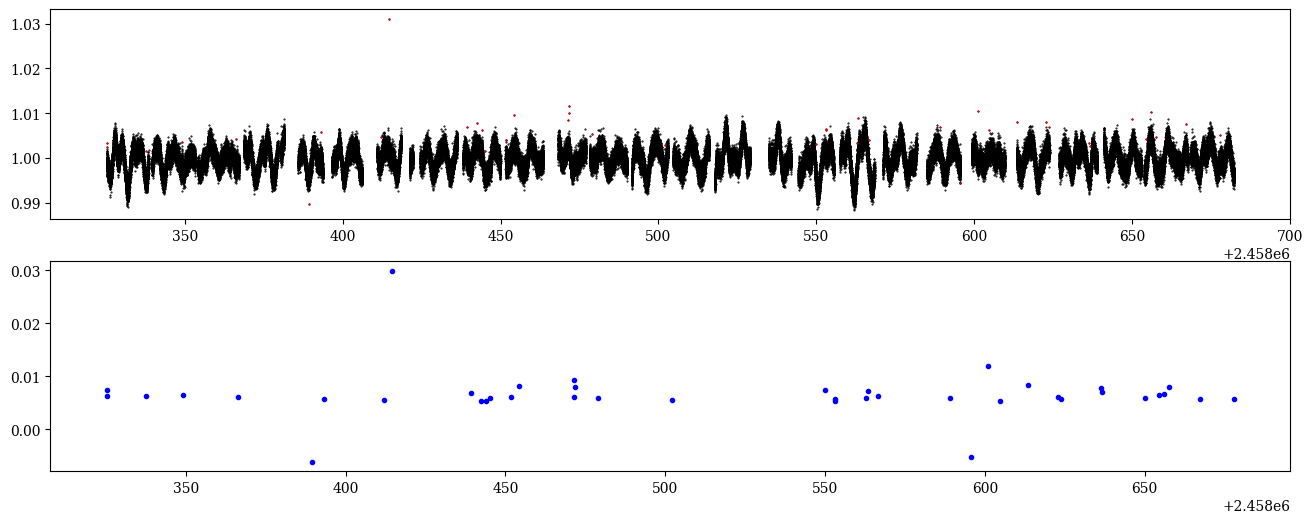

41
0.0001996581462958544
205310


In [6]:
# eliminate tess flux outliers
movingmed = medfilt(tess[:,1],kernel_size=201) #chose this kernel size as covering ~0.05*Prot
print(np.shape(movingmed))
print(np.shape(tess[:,1]))

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(tess[:,0],tess[:,1],'k.',ms=1,zorder=1)
#axes[0].plot(tess[:,0],tess,'r.',zorder=2)
#axes[0].set_ylim(0.99,1.01)


outlierMask = (np.abs(tess[:,1] - movingmed) > 5.*tess[:,2])

axes[0].plot(tess[:,0][outlierMask],tess[:,1][outlierMask],'r.',ms=1,zorder=3)

axes[1].plot(tess[:,0][outlierMask],tess[:,1][outlierMask]-movingmed[outlierMask],'b.')
#axes[1].set_ylim(-0.05,0.05)
plt.show()

print(len(tess[:,0][outlierMask]))
print(len(tess[:,0][outlierMask])/len(tess[:,0]))

tess = tess[~outlierMask]
print(len(tess))

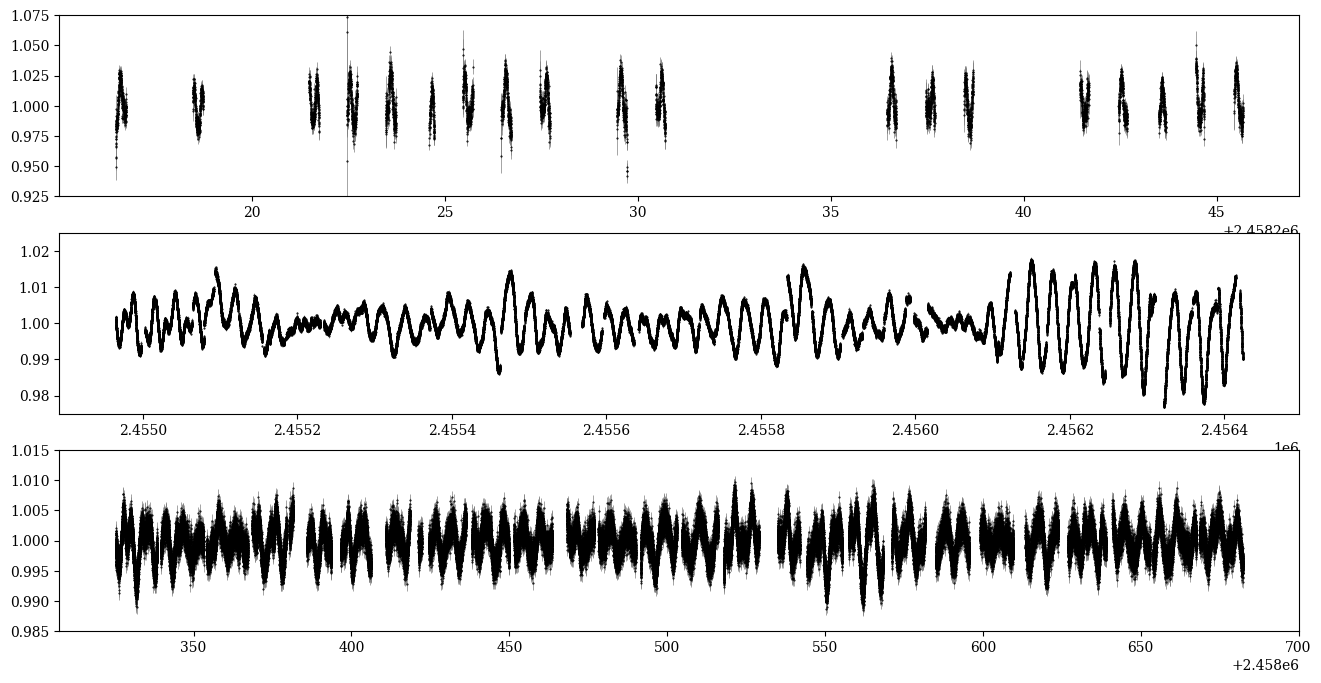

In [7]:
fig, axes = plt.subplots(3,1,figsize=(16,8))
#axes[0].errorbar(speculoos[:,0],speculoos[:,1],yerr=speculoos[:,2],color='k',ls='None',capsize=0)
axes[0].errorbar(speculoos_trunc[:,0],speculoos_trunc[:,1],yerr=speculoos_trunc[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')
axes[1].errorbar(kepler[:,0],kepler[:,1],yerr=kepler[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')
axes[2].errorbar(tess[:,0],tess[:,1],yerr=tess[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')

axes[0].set_ylim(0.925,1.075)
axes[1].set_ylim(0.975,1.025)
axes[2].set_ylim(0.985,1.015)

plt.show()

In [8]:
def find_cadence(timeseries):
    return mode(timeseries[1:] - timeseries[0:-1], keepdims=True)[0][0]

In [9]:
speculoos_trunc_cad = find_cadence(speculoos_trunc[:,0])
kepler_cad = find_cadence(kepler[:,0])
tess_cad = find_cadence(tess[:,0])

In [10]:
# best-fit periods from LS periodograms, in days
speculoos_Prot = 0.21265815403868307
kepler_Prot = 26.536163091164116
tess_Prot = 5.614166939523766

# 4. Rössler x,y,z

In [11]:
a=0.2
b=0.2
c=5.7

fp1, fp2 = sp.Rossler_FPs(a=0.2,b=0.2,c=5.7)
print(fp1)
print(fp2)

[  5.6929738  -28.46486898  28.46486898]
[ 0.0070262  -0.03513102  0.03513102]


In [12]:
r0 = np.array((1.,1.,1.))
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
#r0 = np.array((-7.06916283,  0.71266172,  0.01578853))

# fixed point experiment 
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = np.array((fp1_x, fp1_y, fp1_z))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

rossler = RK45(fun=sp.Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

rossler_r_init = np.empty((Nsteps,3))
rossler_t_init = np.empty((Nsteps))
for i in range(Nsteps):
    rossler.step()
    rossler_t_init[i] = rossler.t
    rossler_r_init[i] = rossler.y
    
    
print(rossler_r_init[5000])

qp_x = sp.estimateQuasiPeriod(np.atleast_2d(rossler_t_init).T, rossler_r_init[:,0])
qp_x_days = qp_x*dt

qp_y = sp.estimateQuasiPeriod(np.atleast_2d(rossler_t_init).T, rossler_r_init[:,1])
qp_y_days = qp_y*dt

qp_z = sp.estimateQuasiPeriod(np.atleast_2d(rossler_t_init).T, rossler_r_init[:,2])
qp_z_days = qp_z*dt

max_qp = np.max(np.array((qp_x,qp_y,qp_z)))
print(max_qp)

[-7.06916283  0.71266172  0.01578853]
628


## Speculoos

In [13]:
r0 = np.array((-7.06916283,  0.71266172,  0.01578853))

#so we need ~321 data points per period, and we need to integrate for ~137 periods.
# fine to integrate at this higher cadence, can downsample later.
new_Nsteps = int(((speculoos_trunc[-1,0] - speculoos_trunc[0,0])*max_qp)/speculoos_Prot)
print(new_Nsteps)

rossler = RK45(fun=sp.Rossler_vel,t0=0.,y0=r0,max_step=dt,t_bound=10000.)

rossler_r = np.empty((new_Nsteps,3))
rossler_t = np.empty((new_Nsteps))
for i in range(new_Nsteps):
    rossler.step()
    rossler_t[i] = rossler.t
    rossler_r[i] = rossler.y
    


86249


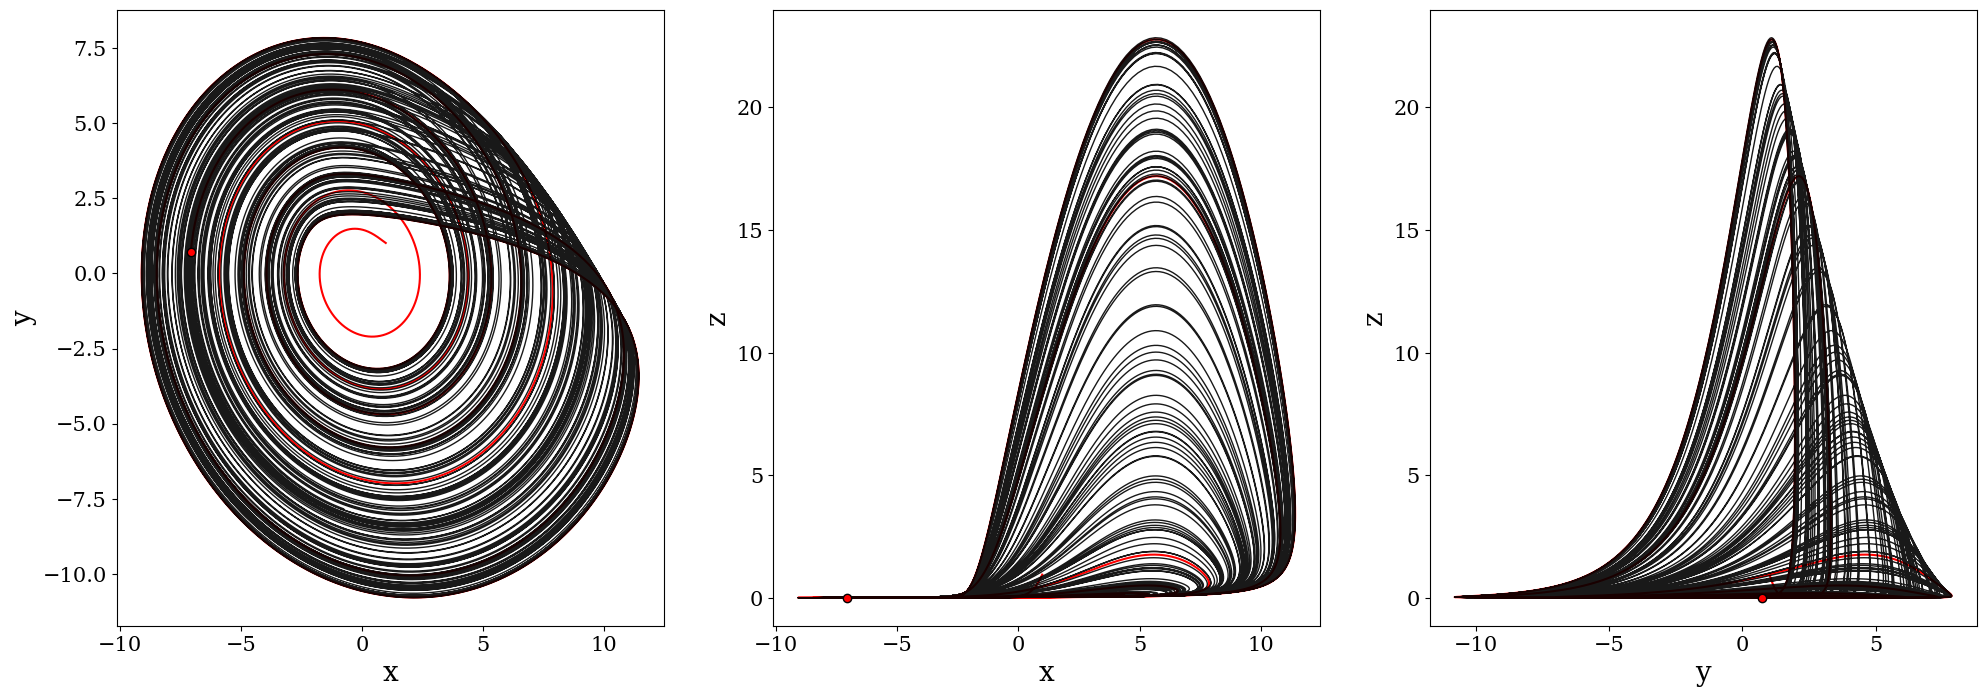

In [14]:
fig, axes = plt.subplots(1,3,figsize=(24,8))

axes[0].plot(rossler_r_init[:5000,0], rossler_r_init[:5000,1], 'r-')
axes[1].plot(rossler_r_init[:5000,0], rossler_r_init[:5000,2], 'r-')
axes[2].plot(rossler_r_init[:5000,1], rossler_r_init[:5000,2], 'r-')

axes[0].plot(rossler_r[:,0], rossler_r[:,1], 'k-',lw=1,alpha=0.9)
axes[1].plot(rossler_r[:,0], rossler_r[:,2], 'k-',lw=1,alpha=0.9)
axes[2].plot(rossler_r[:,1], rossler_r[:,2], 'k-',lw=1,alpha=0.9)

axes[0].plot(rossler_r_init[5000,0], rossler_r_init[5000,1], 'ro',mec='k')
axes[1].plot(rossler_r_init[5000,0], rossler_r_init[5000,2], 'ro',mec='k')
axes[2].plot(rossler_r_init[5000,1], rossler_r_init[5000,2], 'ro',mec='k')

axes[0].set_xlabel("x",fontsize=20)
axes[0].set_ylabel("y",fontsize=20)

axes[1].set_xlabel("x",fontsize=20)
axes[1].set_ylabel("z",fontsize=20)

axes[2].set_xlabel("y",fontsize=20)
axes[2].set_ylabel("z",fontsize=20)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

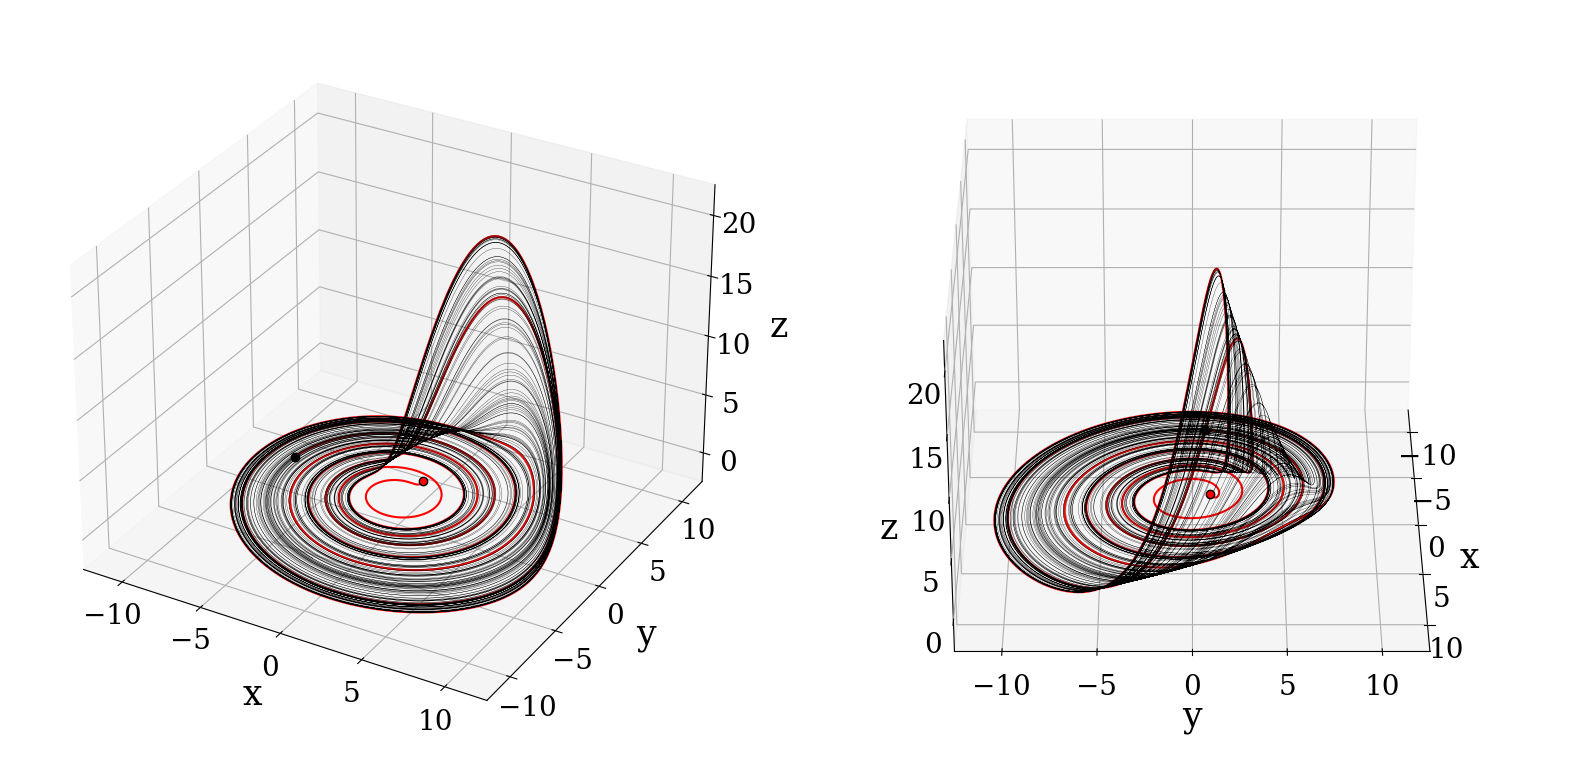

In [15]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
axes = np.array((ax1,ax2))
for ax in axes:
    ax.plot(rossler_r_init[:5000,0], rossler_r_init[:5000,1], rossler_r_init[:5000,2], 'r-')
    ax.plot(rossler_r[:,0], rossler_r[:,1], rossler_r[:,2], 'k-',lw=0.2,alpha=1)
    ax.plot(rossler_r_init[5000,0], rossler_r_init[5000,1], rossler_r_init[5000,2], 'ko',mec='k')
    ax.plot(1,1,1, 'ro',mec='k')

    ax.set_xlabel("x",fontsize=25,labelpad=12)
    ax.set_ylabel("y",fontsize=25,labelpad=12)
    ax.set_zlabel("z",fontsize=25,labelpad=12)

    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_zlim(-2,22)
    ax.tick_params(labelsize=20)
    ax.set_box_aspect(aspect=None, zoom=0.95)


axes[0].view_init(elev=30,azim=300,roll=0)
axes[1].view_init(elev=30, azim=360, roll=0)

plt.subplots_adjust(hspace=0.,wspace=0.05)
#plt.show()
plt.savefig("./rossler_init+speculoos_trajectory.pdf",bbox_inches="tight")

In [16]:
print(rossler_t_init[0:5000])
print(rossler_t)

[-99.99 -99.98 -99.97 ... -50.02 -50.01 -50.  ]
[1.0000e-02 2.0000e-02 3.0000e-02 ... 8.6247e+02 8.6248e+02 8.6249e+02]


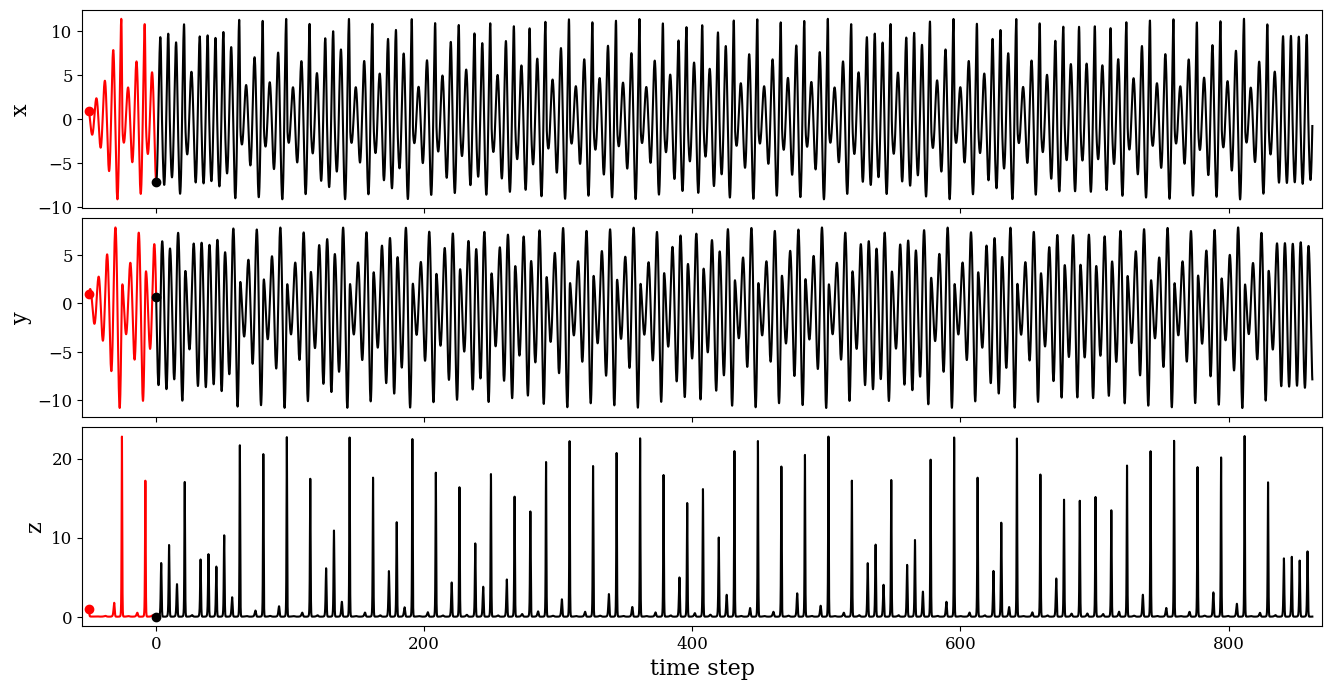

In [17]:
fig, axes = plt.subplots(3,1,figsize=(16,8))

for i in range(3):
    axes[i].plot(rossler_t_init[0]+50,rossler_r_init[0,i],'ro')
    axes[i].plot(rossler_t_init[:5000]+50,rossler_r_init[:5000,i],'r-')
    axes[i].plot(rossler_t[0], rossler_r[0,i],'ko')
    axes[i].plot(rossler_t, rossler_r[:,i],'k-')

axes[0].set_ylabel("x",fontsize=16)
axes[1].set_ylabel("y",fontsize=16)
axes[2].set_ylabel("z",fontsize=16)

axes[2].set_xlabel("time step",fontsize=16)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_xlim(-55,870)
    
#plt.show()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./rossler_timeseries.pdf",bbox_inches="tight")

# 5. Transformed Rössler x,y,z

In [18]:
rossler_fp1 = np.array((0.0070262, -0.03513102, 0.03513102)) # central. strongly attractive in z, repulsive spiral in x, y
rossler_fp2 = np.array((5.6929738, -28.46486898, 28.46486898)) # outlying. repulsive in z, weak attractive spiral in x,y

transformed_rossler_fp1 = (1./np.sqrt(2))*np.array((rossler_fp1[1] + rossler_fp1[2], rossler_fp1[2] + rossler_fp1[0], rossler_fp1[0] + rossler_fp1[1]))
transformed_rossler_fp2 = (1./np.sqrt(2))*np.array((rossler_fp2[1] + rossler_fp2[2], rossler_fp2[2] + rossler_fp2[0], rossler_fp2[0] + rossler_fp2[1]))


r0 = (1.,1.,1.)
# just in case, to avoid transients, choose as IC the 5000th iteration of the above IC
#r0 = np.array((3.6162099,  -5.17683558, -1.58314013))

# fixed point experiment
# need to do it this way because it's very very sensitive to ICs. truncation error is enough to ruin it
# (both unstable! trajectories roll off and down to the attractor.)
fp1_x = 5.6929738
fp1_y = -28.46486898
fp1_z = 28.46486898
#r0 = (1./np.sqrt(2))*np.array((fp1_y + fp1_z, fp1_x+fp1_z, fp1_x+fp1_y))

fp2_x = 0.0070262
fp2_y = -0.03513102
fp2_z = 0.03513102
#r0 = (1./np.sqrt(2))*np.array((fp2_y + fp2_z, fp2_x+fp2_z, fp2_x+fp2_y))

dt = 0.01
tmin = -100.
tmax = 100.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

transformed_rossler_r_init = np.empty((Nsteps,3))
transformed_rossler_t_init = np.empty((Nsteps))
for i in range(Nsteps):
    transformed_rossler.step()
    transformed_rossler_t_init[i] = transformed_rossler.t
    transformed_rossler_r_init[i] = transformed_rossler.y

print(transformed_rossler_r_init[5000])
qp_x = sp.estimateQuasiPeriod(np.atleast_2d(transformed_rossler_t_init).T, transformed_rossler_r_init[:,0])
qp_x_days = qp_x*dt

qp_y = sp.estimateQuasiPeriod(np.atleast_2d(transformed_rossler_t_init).T, transformed_rossler_r_init[:,1])
qp_y_days = qp_y*dt

qp_z = sp.estimateQuasiPeriod(np.atleast_2d(transformed_rossler_t_init).T, transformed_rossler_r_init[:,2])
qp_z_days = qp_z*dt

max_qp = np.max(np.array((qp_x,qp_y,qp_z)))

[ 3.6162099  -5.17683558 -1.58314013]


## Speculoos

In [19]:
r0 = np.array((3.6162099,  -5.17683558, -1.58314013))

new_Nsteps = int(((speculoos_trunc[-1,0] - speculoos_trunc[0,0])*max_qp)/speculoos_Prot)
print(new_Nsteps)

transformed_rossler = RK45(fun=sp.transformed_Rossler_vel,t0=0.,y0=r0,max_step=dt,t_bound=10000.)

transformed_rossler_r = np.empty((new_Nsteps,3))
transformed_rossler_t = np.empty((new_Nsteps))
for i in range(new_Nsteps):
    transformed_rossler.step()
    transformed_rossler_t[i] = transformed_rossler.t
    transformed_rossler_r[i] = transformed_rossler.y
    


86249


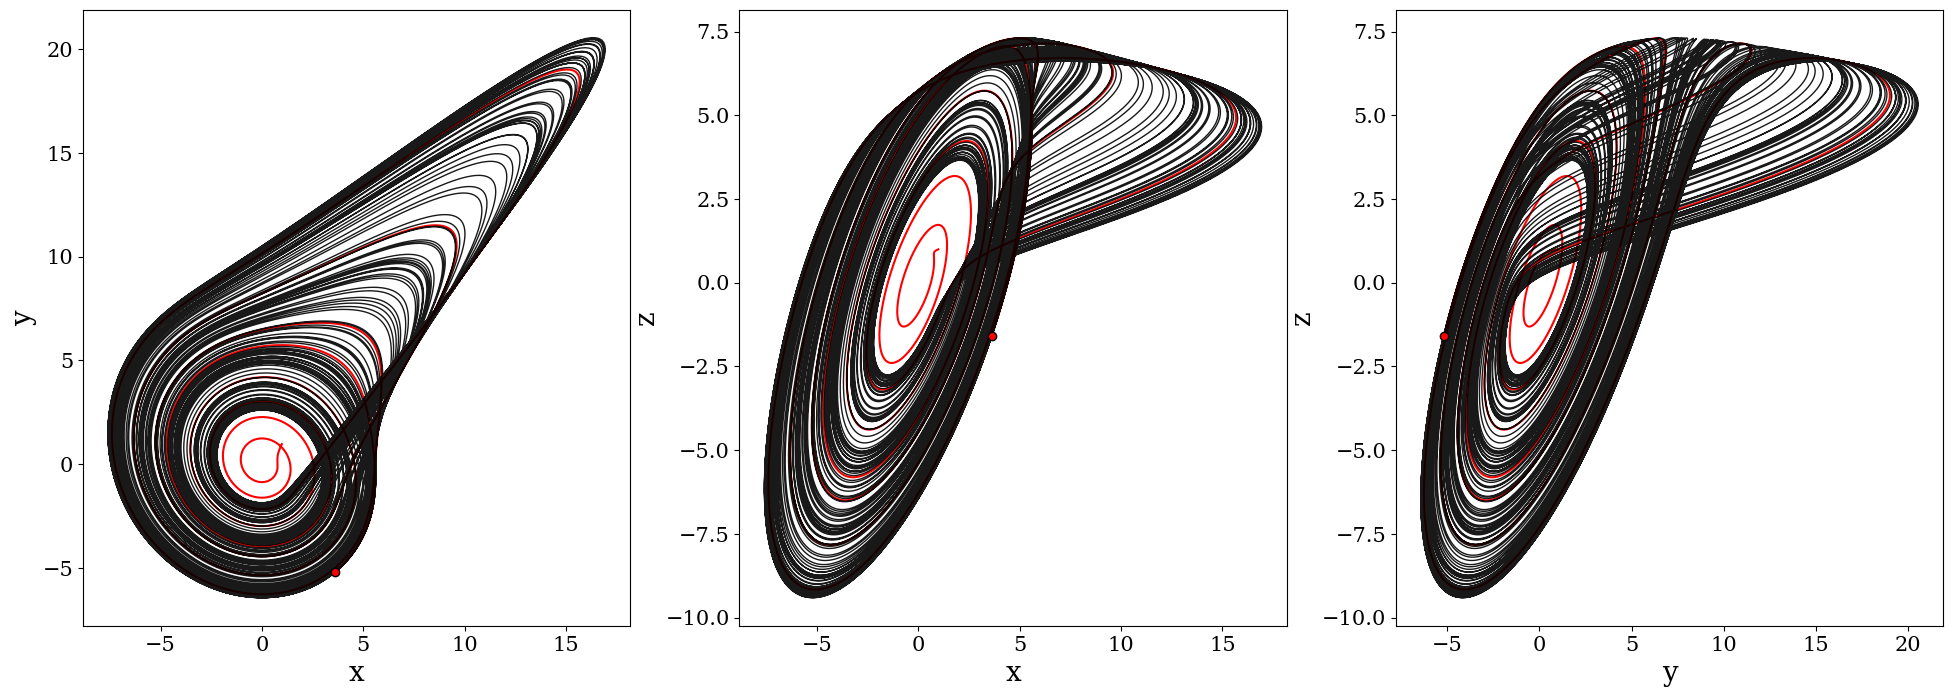

In [20]:
fig, axes = plt.subplots(1,3,figsize=(24,8))

axes[0].plot(transformed_rossler_r_init[:5000,0], transformed_rossler_r_init[:5000,1], 'r-')
axes[1].plot(transformed_rossler_r_init[:5000,0], transformed_rossler_r_init[:5000,2], 'r-')
axes[2].plot(transformed_rossler_r_init[:5000,1], transformed_rossler_r_init[:5000,2], 'r-')

axes[0].plot(transformed_rossler_r[:,0], transformed_rossler_r[:,1], 'k-',lw=1,alpha=0.9)
axes[1].plot(transformed_rossler_r[:,0], transformed_rossler_r[:,2], 'k-',lw=1,alpha=0.9)
axes[2].plot(transformed_rossler_r[:,1], transformed_rossler_r[:,2], 'k-',lw=1,alpha=0.9)

axes[0].plot(transformed_rossler_r_init[5000,0], transformed_rossler_r_init[5000,1], 'ro',mec='k')
axes[1].plot(transformed_rossler_r_init[5000,0], transformed_rossler_r_init[5000,2], 'ro',mec='k')
axes[2].plot(transformed_rossler_r_init[5000,1], transformed_rossler_r_init[5000,2], 'ro',mec='k')

axes[0].set_xlabel("x",fontsize=20)
axes[0].set_ylabel("y",fontsize=20)

axes[1].set_xlabel("x",fontsize=20)
axes[1].set_ylabel("z",fontsize=20)

axes[2].set_xlabel("y",fontsize=20)
axes[2].set_ylabel("z",fontsize=20)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

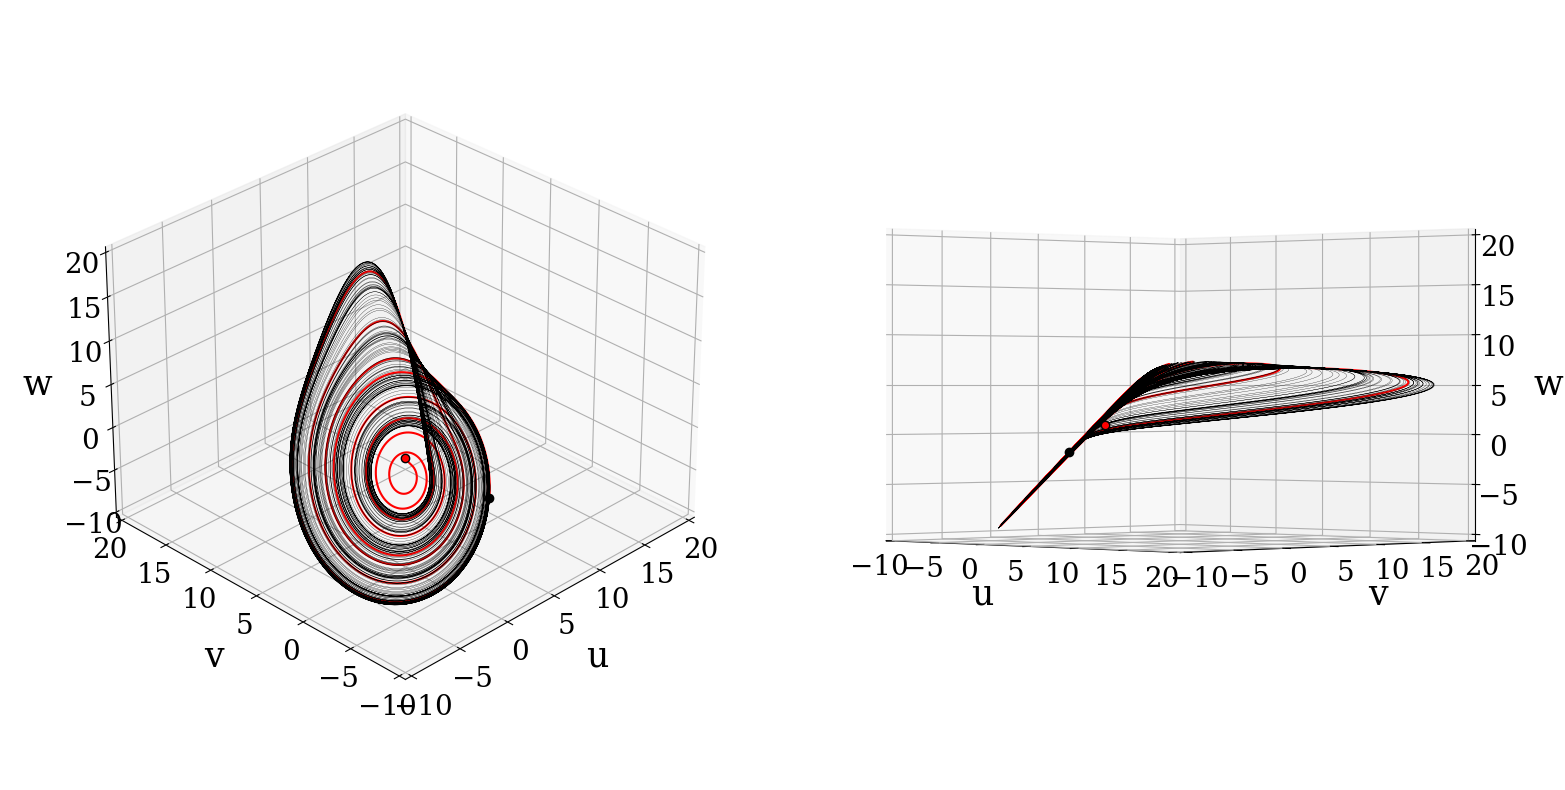

In [21]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
axes = np.array((ax1,ax2))
for ax in axes:
    ax.plot(transformed_rossler_r_init[:5000,0], transformed_rossler_r_init[:5000,1], transformed_rossler_r_init[:5000,2], 'r-')
    ax.plot(transformed_rossler_r[:,0], transformed_rossler_r[:,1], transformed_rossler_r[:,2], 'k-',lw=0.2,alpha=1)
    ax.plot(transformed_rossler_r_init[5000,0], transformed_rossler_r_init[5000,1], transformed_rossler_r_init[5000,2], 'ko',mec='k')
    ax.plot(1,1,1, 'ro',mec='k')

    ax.set_xlabel("u",fontsize=25,labelpad=20)
    ax.set_ylabel("v",fontsize=25,labelpad=20)
    ax.set_zlabel("w",fontsize=25,labelpad=15)
    
    ax.tick_params(labelsize=20)

    ax.set_xlim(-10,20)
    ax.set_ylim(-10,20)
    ax.set_zlim(-10,20)
    ax.set_box_aspect(aspect=None, zoom=0.84)

axes[0].view_init(elev=30, azim=225, roll=0)
#axes[1].view_init(elev=30, azim=350, roll=0)
axes[1].view_init(elev=0,azim=315,roll=0)
plt.subplots_adjust(hspace=0.,wspace=0)
plt.savefig("./transformed_rossler_init+speculoos_trajectory.pdf",bbox_inches="tight")

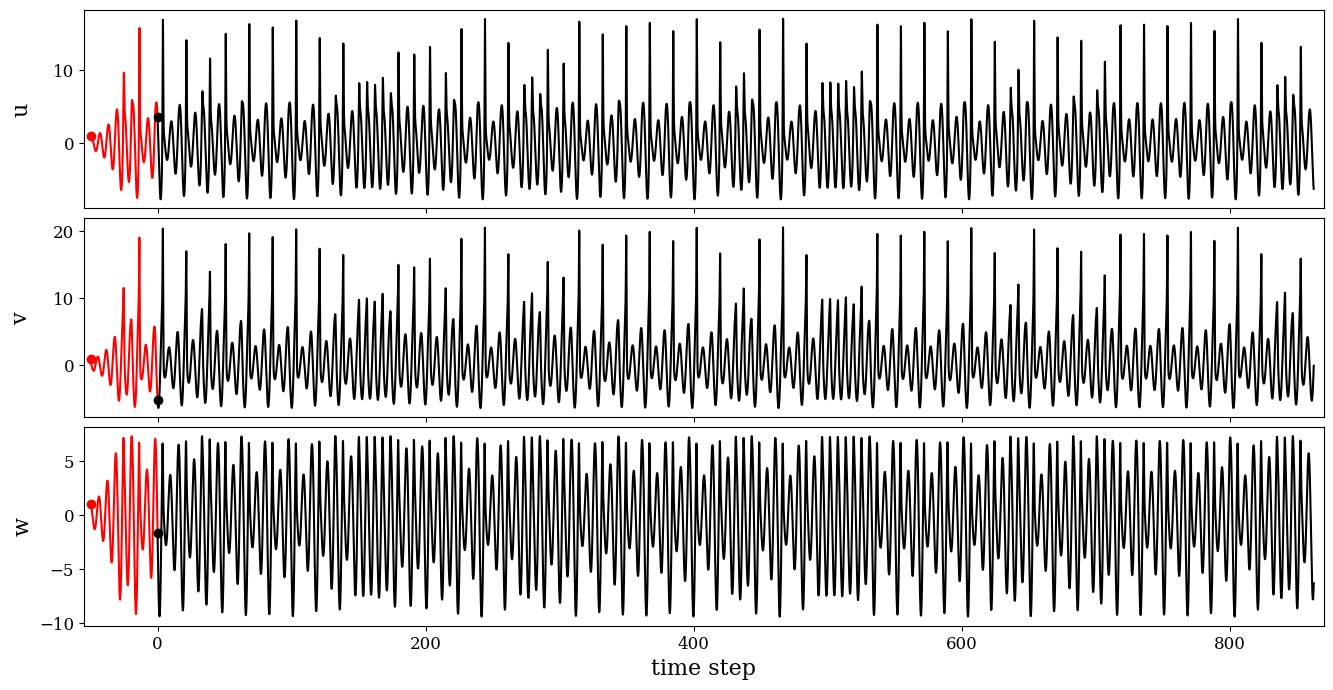

In [22]:
fig, axes = plt.subplots(3,1,figsize=(16,8))

for i in range(3):
    axes[i].plot(transformed_rossler_t_init[0]+50,transformed_rossler_r_init[0,i],'ro')
    axes[i].plot(transformed_rossler_t_init[:5000]+50,transformed_rossler_r_init[:5000,i],'r-')
    axes[i].plot(transformed_rossler_t[0], transformed_rossler_r[0,i],'ko')
    axes[i].plot(transformed_rossler_t, transformed_rossler_r[:,i],'k-')

axes[0].set_ylabel("u",fontsize=16,labelpad=15)
axes[1].set_ylabel("v",fontsize=16,labelpad=15)
axes[2].set_ylabel("w",fontsize=16)

axes[2].set_xlabel("time step",fontsize=16)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_xlim(-55,870)
    
#plt.show()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./transformed_rossler_timeseries.pdf",bbox_inches="tight")

# 6. Lorenz x,y,z

In [62]:
r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
#r0 = np.array((-13.29390985, -16.32060497,  29.90864944))

#fixed point experiments
# because rho > 1, expect 2 fixed points (at the center of the lobes)
# points are both stable if rho < sigma * ((sigma + beta + 3)/(sigma - beta - 1))
# given the choice of parameters above, the RHS of that inequality is ~= 24.7
# so we expect the two FPs to be *unstable*.
fp1_x = 8.48528137
fp1_y = 8.48528137
fp1_z = 27.

fp2_x = -fp1_x
fp2_y = -fp1_y
fp2_z = fp1_z

#r0 = np.array((fp1_x, fp1_y, fp1_z))
#r0 = np.array((fp2_x, fp2_y, fp2_z))

dt = 0.01
tmin = -500.
tmax = 500.
baseline = tmax - tmin
Nsteps = int(baseline/dt)

lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r_init = np.empty((Nsteps,3))
lorenz_t_init = np.empty((Nsteps))
for i in range(Nsteps):
    lorenz.step()
    lorenz_t_init[i] = lorenz.t
    lorenz_r_init[i] = lorenz.y

print(lorenz_r_init[5000])

qp_x = sp.estimateQuasiPeriod(np.atleast_2d(lorenz_t_init).T, lorenz_r_init[:,0],method="localMaxSep")
qp_x_days = qp_x*dt

qp_y = sp.estimateQuasiPeriod(np.atleast_2d(lorenz_t_init).T, lorenz_r_init[:,1],method="localMaxSep")
qp_y_days = qp_y*dt

qp_z = sp.estimateQuasiPeriod(np.atleast_2d(lorenz_t_init).T, lorenz_r_init[:,2])
qp_z_days = qp_z*dt

max_qp = np.max(np.array((qp_x,qp_y,qp_z)))


[-13.29390985 -16.32060497  29.90864944]


In [63]:
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))

new_Nsteps = int(((speculoos_trunc[-1,0] - speculoos_trunc[0,0])*max_qp)/speculoos_Prot)
print(new_Nsteps)

lorenz = RK45(fun=sp.Lorenz_vel,t0=0.,y0=r0,max_step=dt,t_bound=10000.)

lorenz_r = np.empty((new_Nsteps,3))
lorenz_t = np.empty((new_Nsteps))
for i in range(new_Nsteps):
    lorenz.step()
    lorenz_t[i] = lorenz.t
    lorenz_r[i] = lorenz.y
    



10300


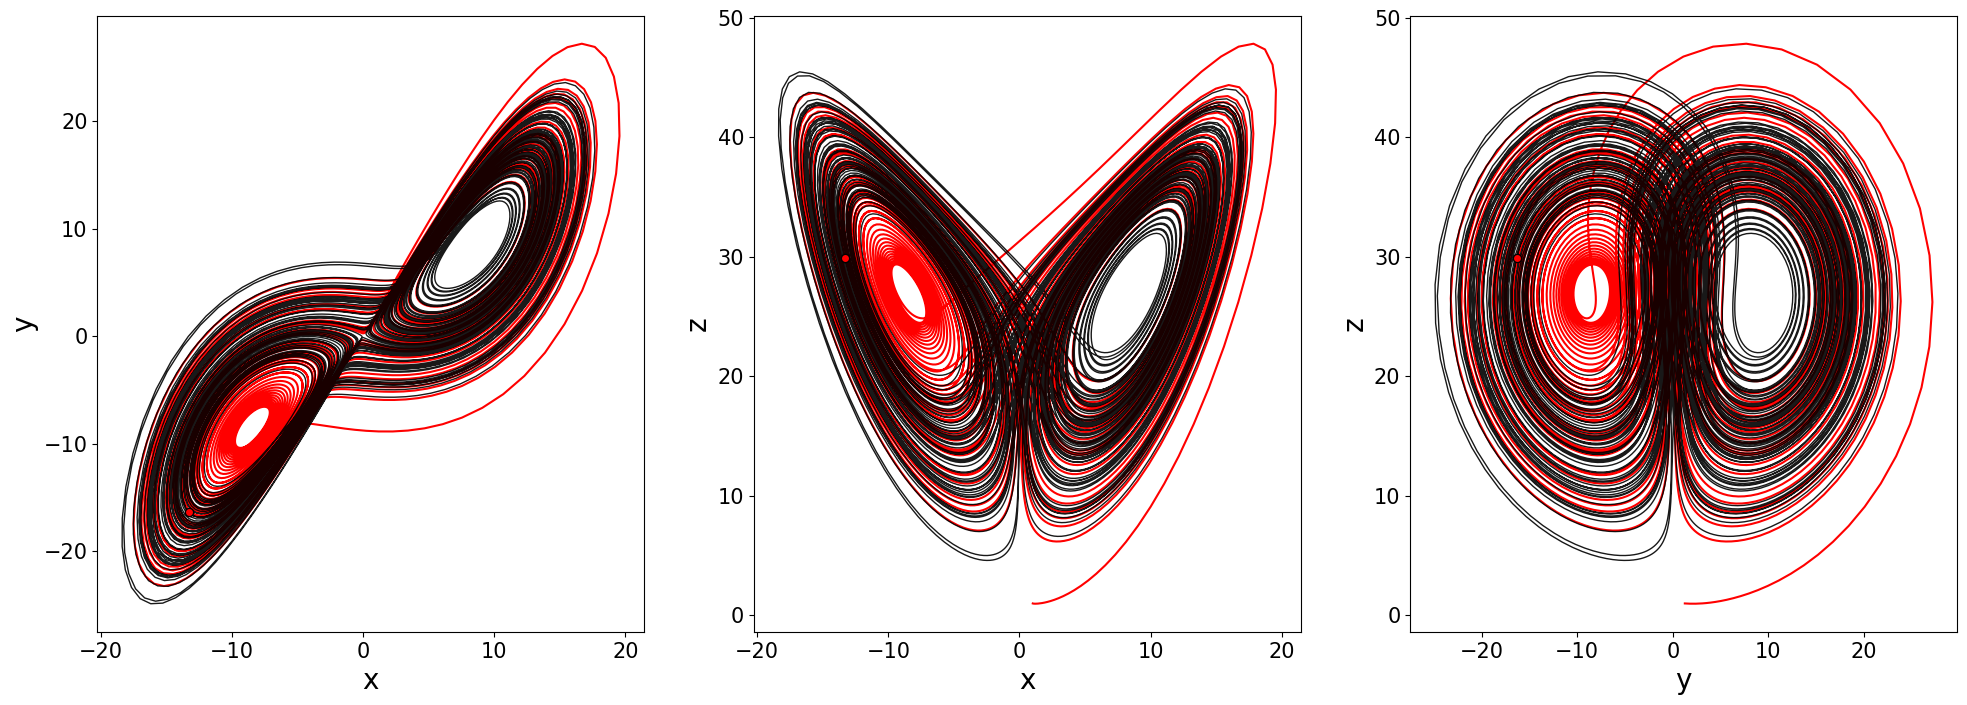

In [85]:
fig, axes = plt.subplots(1,3,figsize=(24,8))

axes[0].plot(lorenz_r_init[:5000,0], lorenz_r_init[:5000,1], 'r-')
axes[1].plot(lorenz_r_init[:5000,0], lorenz_r_init[:5000,2], 'r-')
axes[2].plot(lorenz_r_init[:5000,1], lorenz_r_init[:5000,2], 'r-')

axes[0].plot(lorenz_r[:,0], lorenz_r[:,1], 'k-',lw=1,alpha=0.9)
axes[1].plot(lorenz_r[:,0], lorenz_r[:,2], 'k-',lw=1,alpha=0.9)
axes[2].plot(lorenz_r[:,1], lorenz_r[:,2], 'k-',lw=1,alpha=0.9)

axes[0].plot(lorenz_r_init[5000,0], lorenz_r_init[5000,1], 'ro',mec='k')
axes[1].plot(lorenz_r_init[5000,0], lorenz_r_init[5000,2], 'ro',mec='k')
axes[2].plot(lorenz_r_init[5000,1], lorenz_r_init[5000,2], 'ro',mec='k')

axes[0].set_xlabel("x",fontsize=20)
axes[0].set_ylabel("y",fontsize=20)

axes[1].set_xlabel("x",fontsize=20)
axes[1].set_ylabel("z",fontsize=20)

axes[2].set_xlabel("y",fontsize=20)
axes[2].set_ylabel("z",fontsize=20)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

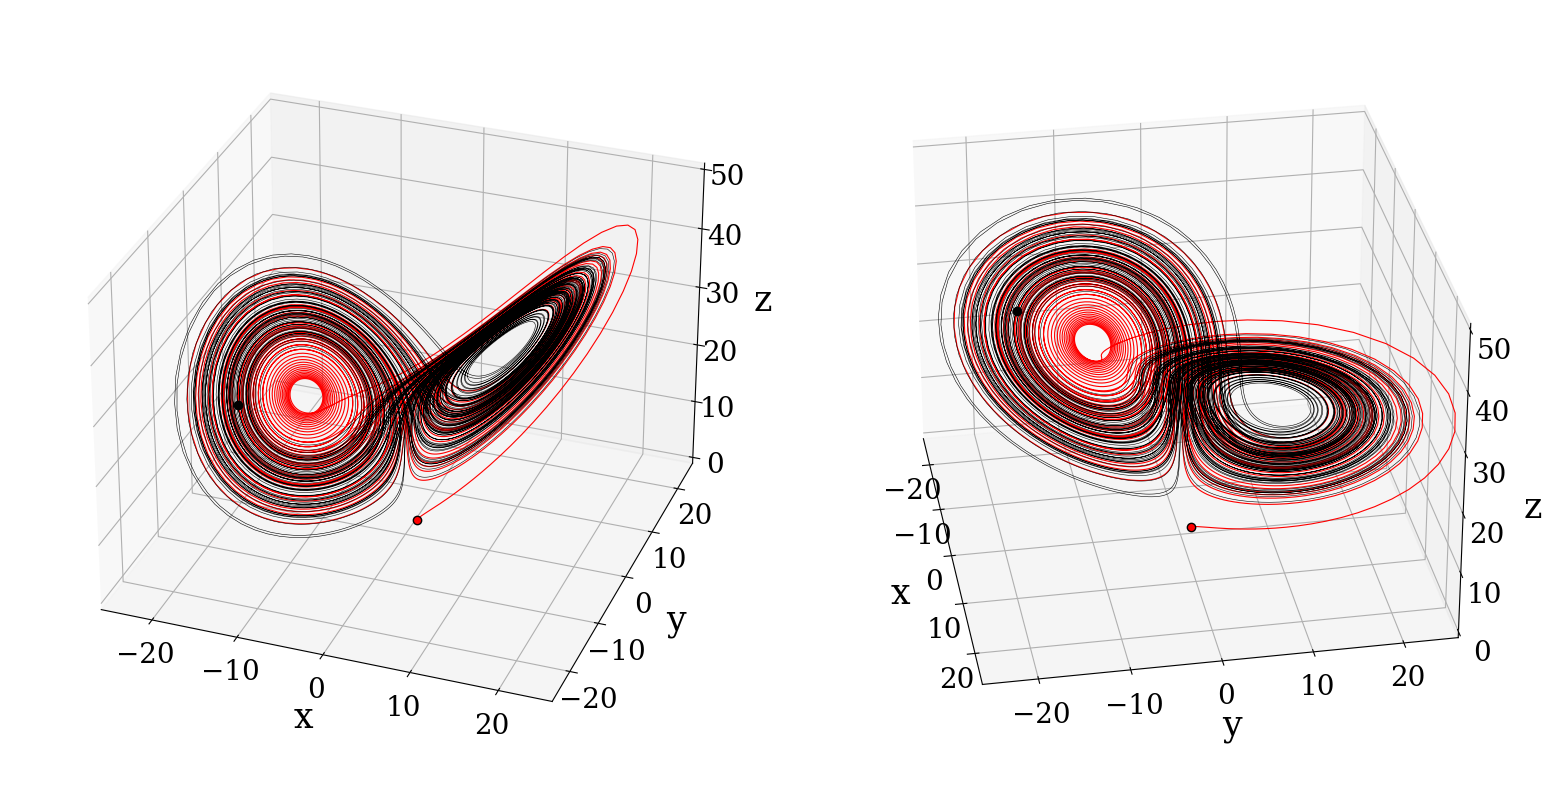

In [76]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
axes = np.array((ax1,ax2))
for ax in axes:
    ax.plot(lorenz_r_init[:5000,0], lorenz_r_init[:5000,1], lorenz_r_init[:5000,2], 'r-',lw=0.8)
    ax.plot(lorenz_r[:,0], lorenz_r[:,1], lorenz_r[:,2], 'k-',lw=0.4,alpha=1)
    ax.plot(lorenz_r_init[5000,0], lorenz_r_init[5000,1], lorenz_r_init[5000,2], 'ko',mec='k')
    ax.plot(1,1,1, 'ro',mec='k')

    ax.set_xlabel("x",fontsize=25,labelpad=12)
    ax.set_ylabel("y",fontsize=25,labelpad=12)
    ax.set_zlabel("z",fontsize=25,labelpad=12)

    ax.tick_params(labelsize=20)

    ax.set_xlim(-25,25)
    ax.set_ylim(-25,25)
    ax.set_zlim(-0,50)
    ax.set_box_aspect(aspect=None, zoom=0.95)

axes[0].view_init(elev=30, azim=290, roll=0)
axes[1].view_init(elev=30, azim=350, roll=0)
plt.subplots_adjust(hspace=0.,wspace=0.)
plt.savefig("./lorenz_init+speculoos_trajectory.pdf",bbox_inches="tight")

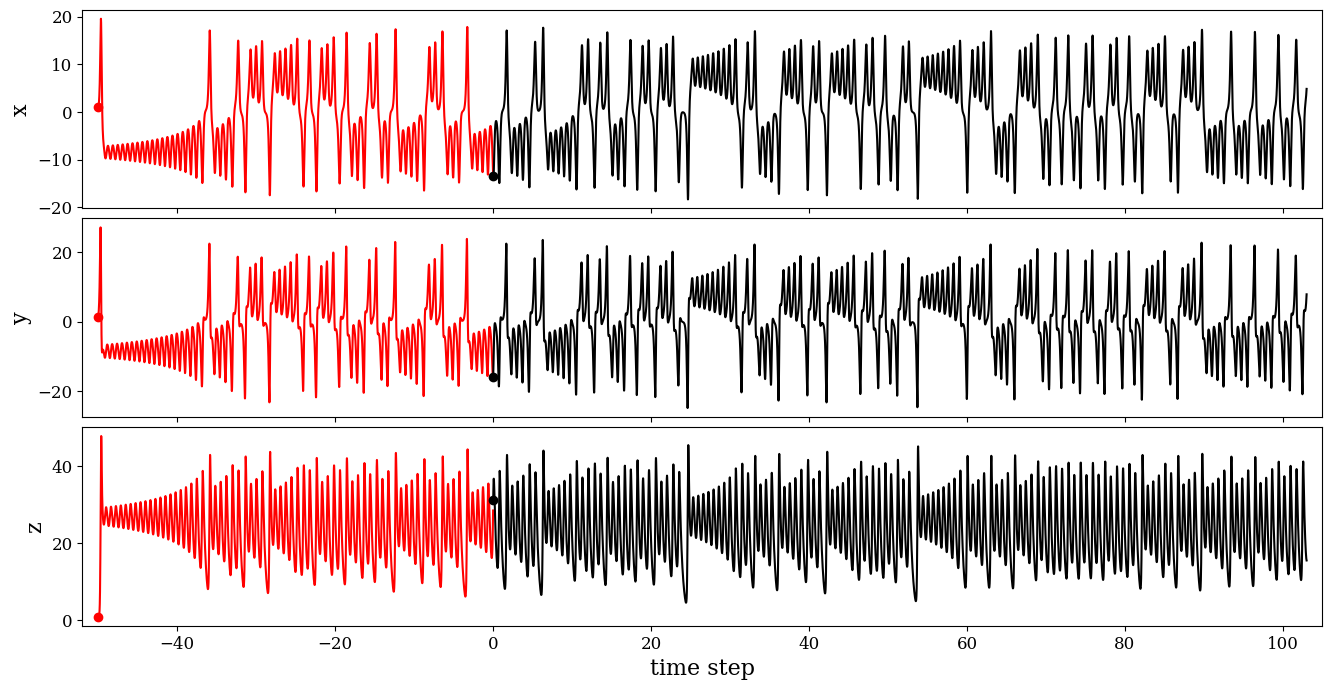

In [104]:
fig, axes = plt.subplots(3,1,figsize=(16,8))

for i in range(3):
    axes[i].plot(lorenz_t_init[0]+450,lorenz_r_init[0,i],'ro')
    axes[i].plot(lorenz_t_init[:5000]+450,lorenz_r_init[:5000,i],'r-')
    axes[i].plot(lorenz_t[0], lorenz_r[0,i],'ko')
    axes[i].plot(lorenz_t, lorenz_r[:,i],'k-')

axes[0].set_ylabel("x",fontsize=16)
axes[1].set_ylabel("y",fontsize=16)
axes[2].set_ylabel("z",fontsize=16)

axes[2].set_xlabel("time step",fontsize=16)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_xlim(-52,105)
    
#plt.show()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./lorenz_timeseries.pdf",bbox_inches="tight")

## Showing perfect, noisy+gapless, noiseless+gappy, realistic versions of the Lorenz x time series.

In [23]:
pwd

'/Users/Emily/Documents/astro/starspot_chaos/realistic_synthetic_data'

In [54]:
perfect = np.genfromtxt("./data/4_rossler/4_rossler_x_speculoos_perfect.txt")
gaps = np.genfromtxt("./data/4_rossler/4_rossler_x_speculoos_gaps.txt")

In [55]:
print(np.shape(perfect))
print(np.shape(gaps))

(44119, 4)
(6758, 4)


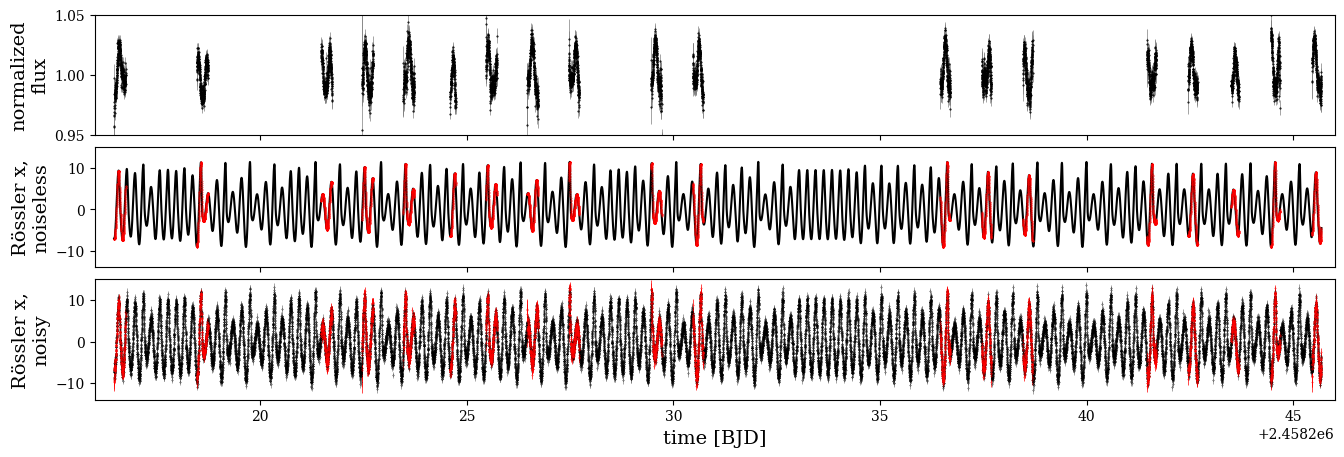

In [64]:
fig, axes = plt.subplots(3,1,figsize=(16,5),sharex=True)
axes[0].errorbar(speculoos_trunc[:,0],speculoos_trunc[:,1],yerr=speculoos_trunc[:,2],color='k',ls='None',marker='.',capsize=0,ms=1,elinewidth=0.5,ecolor='Gray')

axes[1].plot(perfect[:,0],perfect[:,1],'k-')
axes[2].errorbar(perfect[:,0],perfect[:,2],yerr=perfect[:,3],color='k',marker='.',capsize=0,elinewidth=0.5,linestyle='None',ms=0.5,ecolor='Gray')
axes[1].plot(gaps[:,0],gaps[:,1],'r.',ms=0.5)
axes[2].errorbar(gaps[:,0],gaps[:,2],yerr=gaps[:,3],color='r',marker='.',capsize=0,elinewidth=0.5,linestyle='None',ms=0.5,ecolor='r')
for ax in axes:
    ax.set_xlim(2458216,2458246)
for ax in axes[1:]:    
    ax.set_ylim(-14,15)
axes[1].set_ylabel("Rössler x,\nnoiseless",fontsize=14)
axes[2].set_ylabel("Rössler x,\nnoisy",fontsize=14)
axes[2].set_xlabel('time [BJD]',fontsize=14)
axes[0].set_ylabel('normalized\nflux',fontsize=14)
axes[0].set_ylim(0.95,1.05)
plt.subplots_adjust(hspace=0.1)
#plt.show()
plt.savefig("./rossler_x_addednoise.pdf",bbox_inches="tight")

In [60]:
print(np.mean(perfect[:,1]))

0.16945243156009884
